$ \hspace{120pt} EN3160 \quad Assignment \quad 2 \quad on \quad Fitting \quad and \quad Alignment$

$(1) \quad Blob \quad Filter$

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

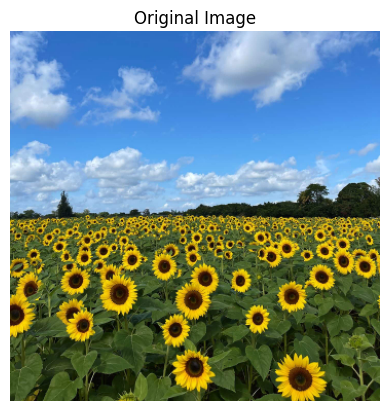

In [2]:
img = cv.imread('the_berry_farms_sunflower_field.jpeg',cv.IMREAD_REDUCED_COLOR_4)
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

#plot image
plt.imshow(img_RGB)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [12]:
# define log kernel
def log_kernel(sigma, size):
    if size % 2 == 0:
        size += 1
    sigma2 = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)
    tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)
    kernel = np.exp(tmp_cal)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    k_sum = np.sum(kernel)
    if k_sum != 0:
        kernel /= np.sum(kernel)
    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return kernel

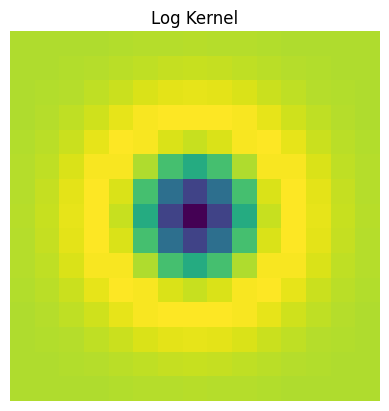

In [13]:
#plot the log kernel
log_kernel = log_kernel(2, 15)

plt.imshow(log_kernel)
plt.title('Log Kernel')
plt.axis('off')
plt.show()

In [24]:
# blob detection
def detect_blobs(img, sigma_scale, threshold):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX)

    sigma0 = np.sqrt(2)
    k = np.sqrt(2)
    num_scales = sigma_scale
    sigmas = sigma0 * np.power(k, np.arange(num_scales))
    sigmas = [num_scales]*num_scales
    
    
    # apply LoG kernel filtering with scaled kernel size and sigma
    img_stack = None
    for i in range(num_scales):
        size = int(2 * np.ceil(4 * sigmas[i]) + 1)
        # with Laplacian response normalization
        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
        filtered = cv.filter2D(gray, cv.CV_32F, kernel)
        filtered = pow(filtered, 2)
        if i == 0:
            img_stack = filtered
        else:
            img_stack = np.dstack((img_stack, filtered))

    # Maximum response extraction
    scale_space = None
    for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
        if i == 0:
            scale_space = filtered
        else:
            scale_space = np.dstack((scale_space, filtered))
    max_stack = np.amax(scale_space, axis=2)
    max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)
    max_stack = np.multiply((max_stack == scale_space), scale_space)

    radius_vec = None
    x_vec = None
    y_vec = None
    for i in range(num_scales):
        radius = np.sqrt(2) * sigmas[i]
        threshold = threshold
        # filter out redundant response
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i]
        valid[valid <= threshold] = 0
        (x, y) = np.nonzero(valid)
        if i == 1:
            x_vec = x
            y_vec = y
            radius_vec = np.repeat(radius, np.size(x))
        else:
            x_vec = np.concatenate((x_vec, x), axis=None)
            y_vec = np.concatenate((y_vec, y), axis=None)
            tmp_vec = np.repeat(radius, np.size(x))
            radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None)

    return x_vec, y_vec, radius_vec

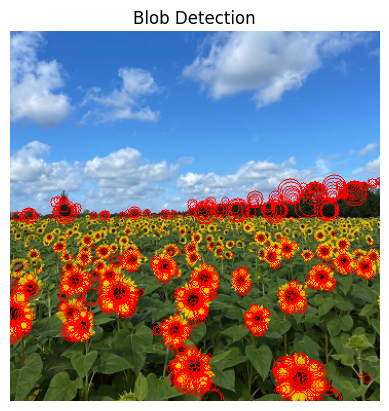

In [42]:
img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
x_all = []
y_all = []
radii_all = []
for sigma_scale in range(2, 10):
    x_coords, y_coords, radii = detect_blobs(img, sigma_scale, 0.03)
    x_all.append(x_coords)
    y_all.append(y_coords)
    radii_all.append(radii)

x_all = np.concatenate(x_all, axis=None)
y_all = np.concatenate(y_all, axis=None)
radii_all = np.concatenate(radii_all, axis=None)

output_img = img.copy()
for i in range(int(len(x_all))):
    cv.circle(output_img, (y_all[i], x_all[i]), int(radii_all[i]), (0, 0, 255), 1)

plt.imshow(cv.cvtColor(output_img, cv.COLOR_BGR2RGB))
plt.title("Blob Detection")
plt.axis('off')
plt.show()


$(2)\quad RANSAC \quad  Algorithm$

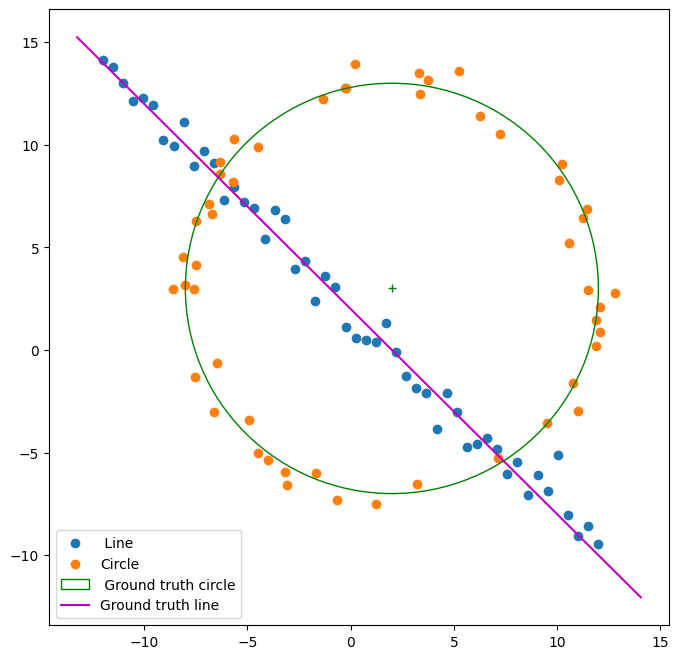

In [118]:
# Generation o f a Noisy Po in t Set Conforming to a Line and a Circle
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib

# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16

t = np.random.uniform (0 ,2*np.pi,half_n)

n = s*np.random.randn( half_n )

x,y = x0_gt + (r + n)*np.cos(t) , y0_gt + (r + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n , 1)))

s = 1.
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 )))
X = np.vstack ( ( X_circ , X_line ) ) # All points


# Plotting
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line'  )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt.Circle(( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= ' Ground truth circle')
ax . add_patch ( circle_gt )
ax.plot((x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim ()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line')
plt . legend ()

$(2) \quad (a) \quad Estimate \quad Best \quad Fitting \quad Line$ 

In [119]:
def Line_RANSAC(points,distance_threshold):
    
    S = 2
    max_iterations = 10000
    
    best_line = None
    best_inliers_index = []
    
    for _ in range(max_iterations):
        
        # Randomly select two points to define a line
        sample_indices = np.random.choice(len(points), size=S, replace=False)
        sample = points[sample_indices]
        
        # Calculate the unit normal vector to the line
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        if x1 == x2:
            continue  # Avoid division by zero
        direction_vector = np.array([y1 - y2, x2 - x1])
        unit_normal_vector = direction_vector / np.linalg.norm(direction_vector)
        d_init =  np.abs(np.dot(unit_normal_vector, np.array([x1, y1])))

        # Calculate the perpendicular distance from the origin to the line
        perpendicular_distances = [np.abs(np.dot(unit_normal_vector, np.array([x, y]))) for x, y in points]
        
        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(perpendicular_distances) if  np.abs(distance-d_init) < distance_threshold]
        
        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_line = (unit_normal_vector, d_init)
            best_inliers_index = inliers_index
            best_fitting_points = sample
            
    return best_line, best_inliers_index, best_fitting_points


$(2) \quad (b) \quad Estimate \quad Best \quad Fitting \quad Circle$ 

In [120]:
#calculate the circle parameters
def circle_equation(params, points):
    h, k, r = params
    residuals = []
    for x, y in points:
        residuals.append((x - h)**2 + (y - k)**2 - r**2)
    return np.array(residuals)

In [121]:
def circle_RANSAC(points,radial_distance_threshold):
    
    S = 3 
    max_iterations = 10000

    best_circle = None
    best_inliers_index = []

    for _ in range(max_iterations):

        # Randomly select three points to define a circle
        sample_indices = np.random.choice(len(points), size=S, replace=False)
        sample = points[sample_indices]

        # Calculate the center and radius of the estimated circle
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        x3, y3 = sample[2]
        
        # use optimizer to get values
        result = minimize(lambda params: np.sum(circle_equation(params, sample)**2), [0,0,1])

        #optimized center coordinates and radius
        h_opt, k_opt, r_opt = result.x

        # Calculate the perpendicular distance from the origin to the circle
        radial_distances = [np.abs(np.sqrt((x - h_opt)**2 + (y - k_opt)**2) - r_opt) for x, y in points]

        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(radial_distances) if distance < radial_distance_threshold]

        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_circle = (np.array([h_opt,k_opt]), r_opt)
            best_inliers_index = inliers_index
            best_fitting_points = sample

    return best_circle, best_inliers_index, best_fitting_points

$(2) \quad (c) \quad ploting \quad all \quad graphs$ 

In [122]:
# Generation o f a Noisy Po in t Set Conforming to a Line and a Circle
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib

# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16

t = np.random.uniform (0 ,2*np.pi,half_n)

n = s*np.random.randn( half_n )

x,y = x0_gt + (r + n)*np.cos(t) , y0_gt + (r + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n , 1)))

s = 1.
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 )))
X = np.vstack ( ( X_circ , X_line ) ) # All points

In [123]:
#estimated line
estimated_line, inliers_index_line,best_fit_points_line = Line_RANSAC(X,1)
x_val = np.linspace(-15, 15, 100)

# calculate the y values of the estimated line
m_est = -estimated_line[0][0] / estimated_line[0][1]
b_est = estimated_line[1] / np.cos(np.arctan(abs(m_est)))
y_val = m_est*x_val + b_est


In [124]:
#estimated circle
points_circle = X.copy()

# remove the inliers of the line from points_circle
points_circle = np.delete(points_circle, inliers_index_line, axis=0)

estimated_circle, inliers_index_circle,best_fit_points_circle = circle_RANSAC(points_circle,1)
theta = np.linspace(0, 2*np.pi, 100)
x_val_circle = estimated_circle[0][0] + estimated_circle[1]*np.cos(theta)
y_val_circle = estimated_circle[0][1] + estimated_circle[1]*np.sin(theta)


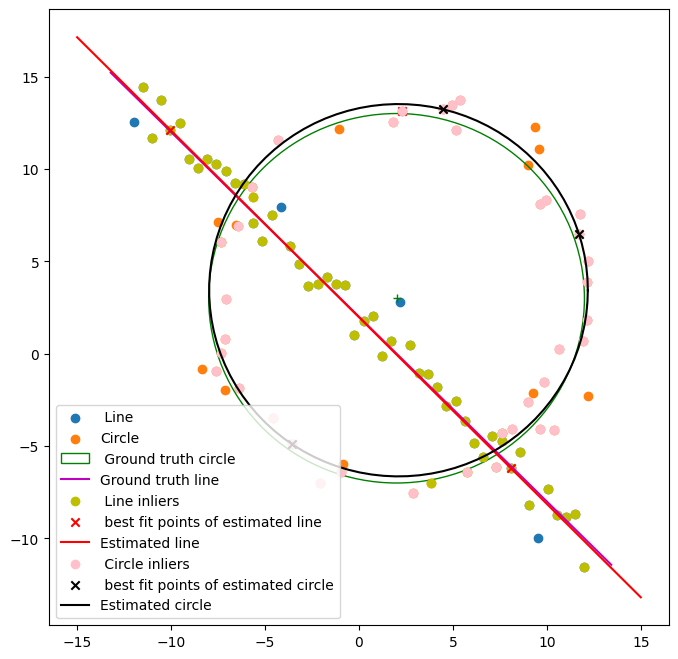

In [125]:
# Plotting
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line'  )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt.Circle(( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= ' Ground truth circle')
ax . add_patch ( circle_gt )
ax.plot((x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim ()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line')
ax . scatter ( X[inliers_index_line][:,0] , X[inliers_index_line][:,1] , color = 'y',label= ' Line inliers'  )
ax . scatter ( np.array(best_fit_points_line)[:,0] , np.array(best_fit_points_line)[:,1] ,marker = 'x', color = 'r',label= ' best fit points of estimated line'  )
ax.plot(x_val, y_val, color='r', label='Estimated line')
ax . scatter ( X[inliers_index_circle][:,0] , X[inliers_index_circle][:,1] , color = 'pink',label= ' Circle inliers'  )
ax . scatter ( np.array(best_fit_points_circle)[:,0] , np.array(best_fit_points_circle)[:,1] , marker = 'x',color = 'k',label= ' best fit points of estimated circle'  )
ax.plot(x_val_circle, y_val_circle, color='k', label='Estimated circle')
plt . legend ()

$(3) \quad Superimposed \quad the \quad Flag$

In [133]:
def mousePoints(event, x, y, flags, params):
    global coordinates
    global count
    global original_image

    if event == cv.EVENT_LBUTTONDOWN:
        coordinates.append([x, y])
        count += 1

        cv.circle(original_image, (x,y), 2, (0, 0, 255), 2)
        cv.imshow("Image", original_image)        
    
    if count == 4:
        cv.destroyAllWindows()
        cv.waitKey(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


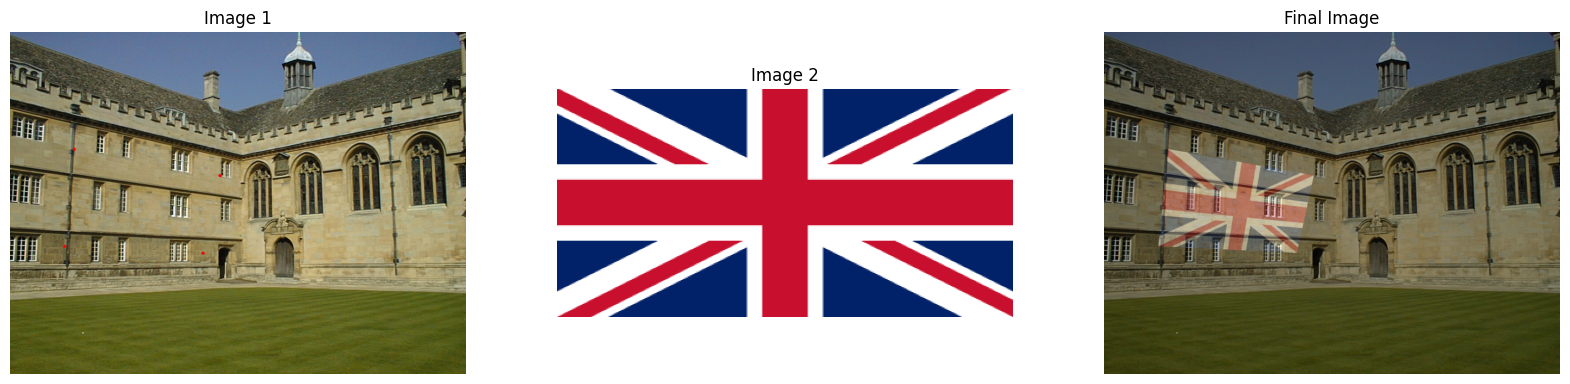

In [134]:
image_1 = cv.imread("001.jpg", cv.IMREAD_COLOR)
image_2 = cv.imread("Flag_of_the_United_Kingdom.png", cv.IMREAD_COLOR)


#normalized the image values
image_1 = image_1.astype(np.float64) / np.iinfo(image_1.dtype).max

image_2 = image_2.astype(np.float64) / np.iinfo(image_2.dtype).max

original_image = image_1.copy()

# clicked coordinates of the image
coordinates = []
count = 0

# open the image to select the points
cv.imshow("Image", image_1)
cv.setMouseCallback("Image", mousePoints)
cv.waitKey(0)

cv.destroyAllWindows()

# 4 corners of the image 
X = np.array([[0, 0, 1],[image_2.shape[1], 0, 1],[image_2.shape[1], image_2.shape[0], 1],[0, image_2.shape[0], 1]]).T

# selected 4 points
Y = np.array([[coordinates[0][0], coordinates[0][1], 1],[coordinates[1][0], coordinates[1][1], 1],[coordinates[2][0],
                 coordinates[2][1], 1],[coordinates[3][0], coordinates[3][1], 1],]).T

# calculate homography matrix
H = cv.findHomography(X[:2].T, Y[:2].T)[0]

# calculate the transformed image
tran_image_2 = cv.warpPerspective(image_2, H, (image_1.shape[1], image_1.shape[0]))

#blending two images
alpha = 0.7
beta = 1 - alpha
blended_img = cv.addWeighted(image_1, alpha, tran_image_2, beta, 0)
blended_img[blended_img > 1] = 1

# convert images to RGB
original_image_rgb = cv.cvtColor(original_image.astype(np.float32), cv.COLOR_BGR2RGB) 
flag_img_rgb = cv.cvtColor(image_2.astype(np.float32), cv.COLOR_BGR2RGB)
superimposed_img_rgb = cv.cvtColor(blended_img.astype(np.float32), cv.COLOR_BGR2RGB)

# plot images
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(original_image_rgb)
ax[1].imshow(flag_img_rgb)
ax[2].imshow(superimposed_img_rgb)

ax[0].set_title("Image 1")
ax[1].set_title("Image 2")
ax[2].set_title("Final Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

plt.show()

$(4) \quad Stitch \quad Two \quad Graffitis$

$(a) \quad Calculate \quad Stitch \quad features$

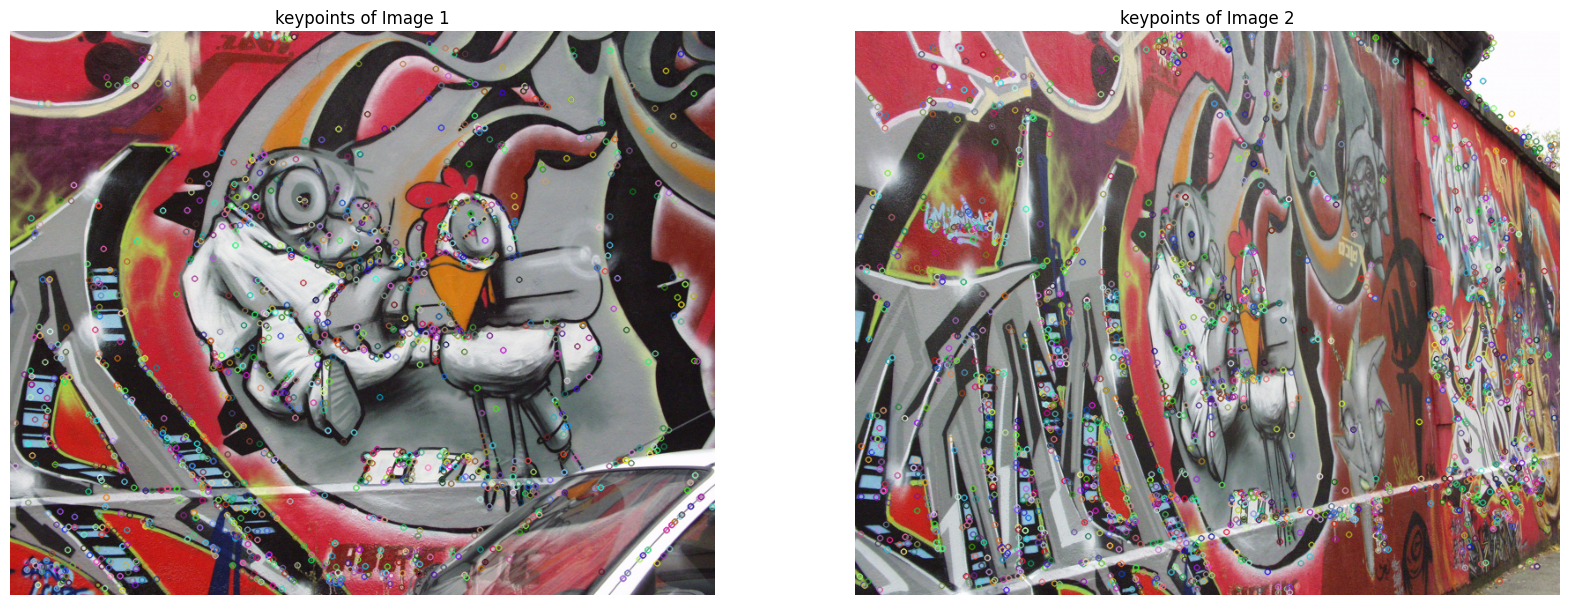

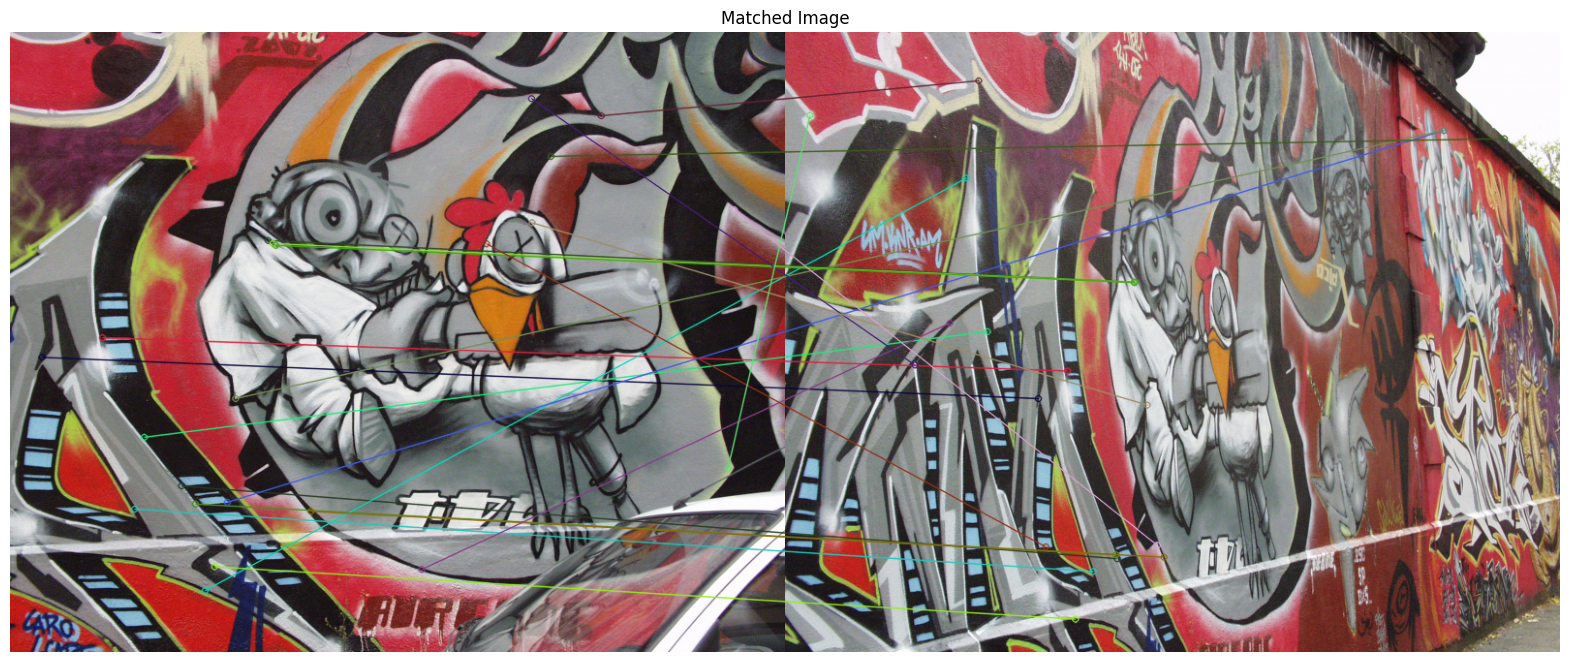

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img1 = cv.imread('img1.ppm',cv.IMREAD_COLOR)
img2 = cv.imread('img5.ppm',cv.IMREAD_COLOR)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

#create a sift object
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.1, edgeThreshold=10, sigma=1)

#detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

#draw keypoints
img1_keypoints = cv.drawKeypoints(img1, kp1, None)
img2_keypoints = cv.drawKeypoints(img2, kp2, None)

#match keypoints
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

#apply ratio test
valid_points = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        valid_points.append([m])

#draw matches
img_matches = cv.drawMatchesKnn(img1, kp1, img2, kp2,valid_points, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# plot key point images and matched image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1_keypoints)
ax[1].imshow(img2_keypoints)
ax[0].set_title("keypoints of Image 1")
ax[1].set_title("keypoints of Image 2")
ax[0].axis("off")
ax[1].axis("off")
plt.show()
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.title("Matched Image")
plt.axis("off")
plt.show()


$(b) \quad Compute \quad Homography \quad using \quad RANSAC $

In [130]:
# Define a function to compute the Euclidean distance between two points after applying the homography
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate

    return np.linalg.norm(p2.T - p2_estimate)


# Define a function for RANSAC-based homography estimation
def RANSAC_homography(points1, points2, threshold=40, num_iterations=100, min_inlier_count=10):
    inlier_count, selected_inliers, best_H = 0, None, None
    points = np.hstack((points1, points2))

    for _ in range(num_iterations):
        np.random.shuffle(points)
        POINTS1, POINTS1_rem, POINTS2, POINTS2_rem = points[:4, :2], points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = cv.findHomography(POINTS1, POINTS2)[0]
        inliers = [(POINTS1_rem[i], POINTS2_rem[i]) for i in range(len(POINTS1_rem)) if dist(POINTS1_rem[i], POINTS2_rem[i], H) < threshold]

        if len(inliers) > inlier_count and len(inliers) >= min_inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)
            best_H = H

    return best_H

In [131]:
from scipy import linalg
# Detect keypoints and compute descriptors for both images using SIFT
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.08, edgeThreshold=12, sigma=0.9)

#Loading the images
IMG2 = cv.imread('img1.ppm')
IMG1 = cv.imread('img5.ppm')

key_points_1, Descriptor_1 = sift.detectAndCompute(IMG1, None)
key_points_2, Descriptor_2 = sift.detectAndCompute(IMG2, None)

# Create a Brute-Force Matcher and perform keypoint matching
bf = cv.BFMatcher()
matches = bf.knnMatch(Descriptor_1, Descriptor_2, k=2)
good, POINTS1, POINTS2 = [], [], []

# Apply the ratio test to filter good matches and extract corresponding keypoints
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        POINTS1.append(key_points_1[m.queryIdx].pt)
        POINTS2.append(key_points_2[m.trainIdx].pt)

# Convert lists to NumPy arrays for further processing
good, POINTS1, POINTS2 = np.array(good), np.array(POINTS1), np.array(POINTS2)

#calculate homography using RANSAC using build in function
H = RANSAC_homography(POINTS2, POINTS1)

# # Print the computed homography matrix
print(H)

[[ 5.90970205e-01  2.57665638e-02  2.24386771e+02]
 [ 2.07077242e-01  1.09334071e+00 -1.68916590e+01]
 [ 4.29459424e-04 -1.35640806e-04  1.00000000e+00]]


$(C) \quad Stitch \quad the \quad Image$

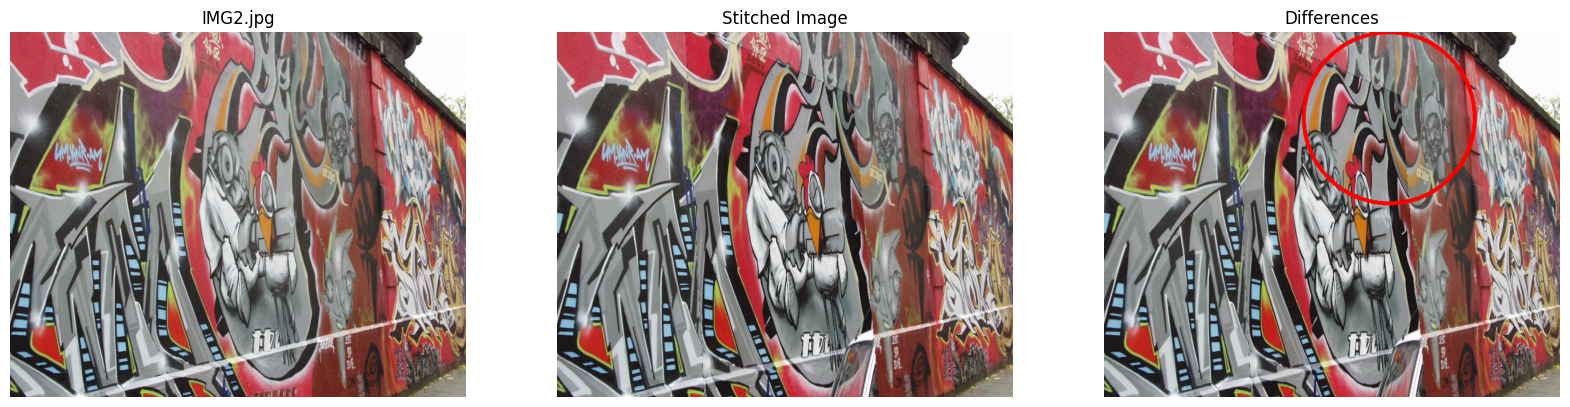

In [137]:
# Convert the list of tuples to a NumPy array
H = np.array(H)

# Warp IMG1 using the perspective transformation matrix H to match the shape of IMG2
img_p = cv.warpPerspective(IMG2, H, (IMG1.shape[1], IMG1.shape[0]))

# Threshold the warped image to create a binary mask
# Pixels with values above 10 become 1, and pixels below 10 become 0 (inverted)
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)

# Multiply the binary mask with IMG2 to extract the common region
IMG1_THRESHOLD = np.multiply(threshold, IMG1)

# Blend the thresholded image with the warped image
BLENDED_IMG = cv.addWeighted(IMG1_THRESHOLD, 1, img_p, 1, 0)

# Create a figure with three subplots for visualization
fig, ax = plt.subplots(1,3, figsize=(20, 20))

# Display IMG2
ax[0].imshow(cv.cvtColor(IMG1, cv.COLOR_BGR2RGB))
ax[0].set_title("IMG2.jpg")
ax[0].axis("off")

# Display the stitched image
ax[1].imshow(cv.cvtColor(BLENDED_IMG, cv.COLOR_BGR2RGB))
ax[1].set_title("Stitched Image")
ax[1].axis("off")

# Add a circle to highlight the difference between the images
BLENDED_IMG = cv.circle(BLENDED_IMG, (500, 150), 150, (0, 0, 255), 5)

# Display the image with the circle
ax[2].imshow(cv.cvtColor(BLENDED_IMG, cv.COLOR_BGR2RGB))
ax[2].set_title("Differences")
ax[2].axis("off")

# Show the figure with the subplots
plt.show()